# HW4_programQuestion

**Due to 11:55 am, 6th, November 2019**

**This is an individual assignment.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from hw4_ref import (PolynomialFeature, 
                     Classifier, 
                     LabelTransformer, 
                     Regression, 
                     LabelTransformer,
                     RandomVariable,
                     Gamma,
                     Gaussian)

np.random.seed(1234)

In [2]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1.
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

## 1. Discriminant Functions

### 1.1 Least squares for classification

In [3]:
class LeastSquaresClassifier(Classifier):
    """
    Least squares classifier model

    X : (N, D)
    W : (D, K)
    y = argmax_k X @ W
    """

    def __init__(self, W:np.ndarray=None):
        self.W = W

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        least squares fitting for classification

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) or (N, K) np.ndarray
            training dependent variable
            in class index (N,) or one-of-k coding (N,K)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.W = np.linalg.pinv(X) @ t

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return np.argmax(X @ self.W, axis=-1)

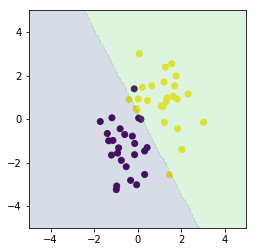

In [4]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(X_train, y_train)
y = model.classify(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 1.2 Linear Regression

In [5]:
class LinearRegression(Regression):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        # Complete your code here

        return y


### 1.3 Logistic Regression

In [11]:
class LogisticRegression(Classifier):
    """
    Logistic regression model

    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    @staticmethod
    def _sigmoid(a):
        # Complete your code here
        # return the results with sigmoid function
        return 1 / (1 + np.exp(-a))

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        maximum likelihood estimation of logistic regression model

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        w = np.zeros(np.size(X, 1))
        for _ in range(max_iter):
            w_prev = np.copy(w)
            y = self._sigmoid(X @ w)
            grad = X.T @ (y - t)
            hessian = (X.T * y * (1 - y)) @ X
            try:
                w -= np.linalg.solve(hessian, grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, w_prev):
                break
        self.w = w

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging class 1

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable

        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        return self._sigmoid(X @ self.w)

    def classify(self, X:np.ndarray, threshold:float=0.5):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified
        threshold : float, optional
            threshold of binary classification (default is 0.5)

        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        
        # Complete your code here
        y = self.proba(X)
        y[y < 0.5] = 0
        y[y >= 0.5] = 1
        return y


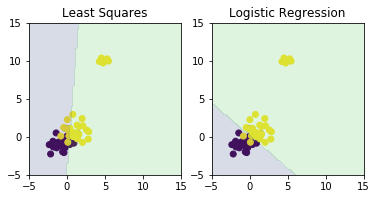

In [12]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_outliers=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least Squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Logistic Regression")
plt.show()

### 1.4 Softmax Regression

In [13]:
class SoftmaxRegression(Classifier):
    """
    Softmax regression model
    aka
    multinomial logistic regression,
    multiclass logistic regression,
    maximum entropy classifier.

    y = softmax(X @ W)
    t ~ Categorical(t|y)
    """

    @staticmethod
    def _softmax(a):
        # Complete your code here
        return np.exp(a)/np.sum(np.exp(a),axis=0)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100, learning_rate:float=0.1):
        """
        maximum likelihood estimation of the parameter

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) or (N, K) np.ndarray
            training dependent variable
            in class index or one-of-k encoding
        max_iter : int, optional
            maximum number of iteration (the default is 100)
        learning_rate : float, optional
            learning rate of gradient descent (the default is 0.1)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.n_classes = np.size(t, 1)
        W = np.zeros((np.size(X, 1), self.n_classes))
        for _ in range(max_iter):
            W_prev = np.copy(W)
            y = self._softmax(X @ W)
            grad = X.T @ (y - t)
            W -= learning_rate * grad
            if np.allclose(W, W_prev):
                break
        self.W = W

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging each class

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        (N, K) np.ndarray
            probability of each class
        """
        return self._softmax(X @ self.W)

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return np.argmax(self.proba(X), axis=-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


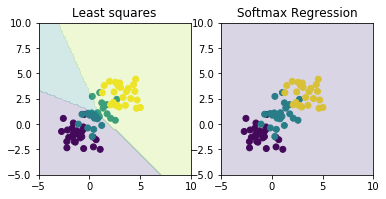

In [14]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_class=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = SoftmaxRegression()
logistic_regression.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Softmax Regression")
plt.show()

### 1.5 Fisher's linear discriminant

In [70]:
class FishersLinearDiscriminant(Classifier):
    """
    Fisher's Linear discriminant model
    """

    def __init__(self, w:np.ndarray=None, threshold:float=None):
        self.w = w
        self.threshold = threshold

    def fit(self, X:np.ndarray, t:np.ndarray, k:np.int):
        """
        estimate parameter given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training dataset independent variable
        t : (N,) np.ndarray
            training dataset dependent variable
            binary 0 or 1
        """
        # Complete your code here
        #data = np.concatenate((X, t.reshape(X.shape[0],1)), axis=1)
        
        #get samples per label
        X_classify = {}
        label_ = list(set(t))
        for label in label_:
            X_label = np.array([X[i] for i in range(len(X)) if t[i] == label])
            X_classify[label] = X_label
        
        #calculate mean per label
        mju = np.mean(X, axis=0)
        mju_classify = {}
        for label in label_: 
            mju_label = np.mean(X_classify[label], axis=0)
            mju_classify[label] = mju_label

        # calculate within-class scatter matrix
        #St = np.dot((X - mju).T, X - mju)
        Sw = np.zeros((len(mju), len(mju)))  
        for i in label_:
            Sw += np.dot((X_classify[i] - mju_classify[i]).T,X_classify[i] - mju_classify[i])

        # calculate between-class scatter matrix
        # Sb=St-Sw
        Sb = np.zeros((len(mju), len(mju)))  
        for i in label_:
            Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape((len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))

        # Calculate the eigenvalues and eigenmatrices of Sw-1*Sb
        eig_vals, eig_vecs = np.linalg.eig( np.linalg.inv(Sw).dot(Sb))  

        sorted_indices = np.argsort(eig_vals)
        topk_eig_vecs = eig_vecs[:, sorted_indices[:-k - 1:-1]]  # get top k feature vectors
        self.w = topk_eig_vecs

    def transform(self, X:np.ndarray):
        """
        project data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        y : (N,) np.ndarray
            projected data
        """
        return X @ self.w

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        return (X @ self.w > self.threshold).astype(np.int)

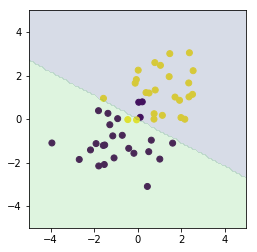

In [72]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

model = FishersLinearDiscriminant(threshold=0.0)
model.fit(x_train, y_train, k=1)
y = model.classify(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 2. Probabilistic Discriminative Models

### 2.1 Logistic Regression

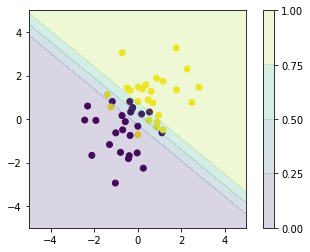

In [73]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LogisticRegression()
model.fit(X_train, y_train)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.2 Multiclass logistic regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


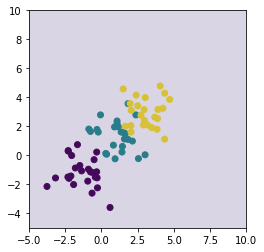

In [74]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_class=True)
x1, x2 = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x = np.array([x1, x2]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X = feature.transform(x)

model = SoftmaxRegression()
model.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y = model.classify(X)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1, x2, y.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.3 Bayesian Logistic Regression

In [75]:
#http://weirping.coding.me/blog/Bayesian-Probabilities-in-ML.html
class BayesianRegression(Regression):
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """
        #prior mean and precision
        mean_prev, precision_prev = self._get_prior(np.size(X, 1))
        #posterior precision 
        w_precision = precision_prev + self.beta * X.T @ X
        #posterior mean 
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision) #inverse matrix of posterior precision

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

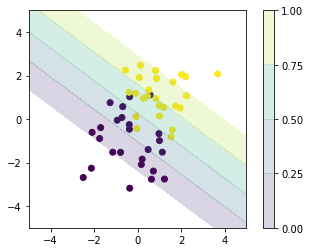

In [78]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model =  BayesianRegression()
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [167]:
#reference: PRML chapter4.5
class BayesianLogisticRegression(LogisticRegression):
    """
    Logistic regression model

    w ~ Gaussian(0, alpha^(-1)I)
    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    def __init__(self, alpha:float=1.):
        self.alpha = alpha
    
    def _get_prior(self, ndim:int) -> tuple:
        return np.zeros(ndim), self.alpha * np.eye(ndim)    
        
    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        bayesian estimation of logistic regression model
        using Laplace approximation

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        # Complete your code here
        #prior mean and precision
        mean_prev, precision_prev = self._get_prior(np.size(X, 1))
        #dram samples from prior Gaussian
        w_prior = np.random.multivariate_normal(mean_prev, precision_prev)
        #calculate the posterior of mean and precision
        w_post = w_prior
        H = precision_prev
        for i in range(max_iter):
            y = self._sigmoid(X@w_prior)
            w_grad = precision_prev@(w_prior-mean_prev)+ (y-t)@X
            H = precision_prev + (y@(1-y))*(X.T@X) 
            w_post = w_prior - np.linalg.inv(H)@w_grad
        
        self.w_mean = w_post
        self.H = np.linalg.inv(H)
        

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging class 1

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable

        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        mu_a = X @ self.w_mean
        # Complete your code here
        # compute the var_a with numpy approaches
        var_a = (X@self.H@X.T).var()
        
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8)) #Laplace approximation

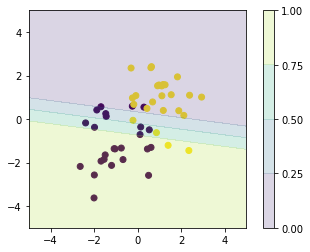

In [168]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianLogisticRegression(alpha=1.)
model.fit(X_train, y_train, max_iter=1000)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()